# Архитектура Трансформера и Токенизация BPE

В этой домашней работе вам предоставится уникальная возможность обучить Byte-level BPE токенизатор и небольшую LM.  

Домашняя работа состоит из нескольких последовательных блоков: реализация и обучение токенизатора, реализация Transformer модели и обучение модели на датасете с русскими анекдотами!

Обученные токенизатор и модель можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

In [ ]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets livelossplot

In [ ]:
# Необходимые импорты

import inspect
import json
import os
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

In [ ]:
# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)


def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")

In [ ]:
interpreter_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

Enter your token (input will not be visible): ··········
Add token as git credential? [y/N]: n


In [ ]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw1" 

print(f"Homework repository: '{REPO_NAME}'")


SEED = 0xC0FFEE

Homework repository: 'pdanich/llm-course-hw1'


# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [ ]:
# Загружаем датасет как обычный JSON файл по прямой ссылке
data_url = "https://huggingface.co/datasets/IgorVolochay/russian_jokes/resolve/main/dataset.json"
dataset = load_dataset("json", data_files=data_url, split="train")

# Смотрим, какие колонки есть
print(f"Columns: {dataset.column_names}")

# Если колонка называется 'jokes', переименовываем её в 'text',
# так как дальнейший код домашки ожидает именно 'text'
if "jokes" in dataset.column_names:
    dataset = dataset.rename_column("jokes", "text")

# Проверяем, что всё работает
print("\n===\n".join(dataset["text"][:3]))

dataset.json:   0%|          | 0.00/44.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Columns: ['jokes']
- Зять, а ты знаешь, где найти того мужчину, который спас меня, когда я тонула?- Да, он уже приходил ко мне извиняться!
 
===
После проведения акции "К животным по-человечески" животные посовещались
 и решили провести акцию "К человеку по-скотски".
 
===
Штирлиц пришел домой и сразу завалился на боковую. Средняя от досады заплакала.
 


In [ ]:
# Подготовим холдауты
# dataset — это уже "train" сплит, поэтому сразу вызываем метод разделения
dataset = dataset.train_test_split(test_size=0.1, seed=SEED)

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 135497
    })
    test: Dataset({
        features: ['text'],
        num_rows: 15056
    })
})


# Токенизатор [3 балла]

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов

In [ ]:


WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [ ]:
def merge(merge_pair: tuple[str, str], pair_frequences: Counter[tuple[str, str]], words_by_tokens: Counter[tuple[str]]):
    """Merges a given pair of tokens and update corresponding stats

    Args:
        merge_pair: The pair of tokens to be merged.
        pair_frequences: A counter tracking the frequency of token pairs in the dataset.
        words_by_tokens: A counter mapping tokenized words to their frequencies.

    Returns:
        Updated pair frequences and word tokenization w.r.t. to new token.
    """
    first, second = merge_pair
    new_token = "".join(merge_pair)

    # Проходим по копии списка слов (так как будем менять словарь)
    for word, count in list(words_by_tokens.items()):

        # Быстрая проверка: если нет обоих токенов, пару точно не составить
        # (не обязательно, но ускоряет)
        if first not in word or second not in word:
            continue

        # Пытаемся собрать новое слово
        new_word_list = []
        i = 0
        changed = False

        while i < len(word):
            if i < len(word) - 1 and word[i] == first and word[i+1] == second:
                new_word_list.append(new_token)
                i += 2
                changed = True
            else:
                new_word_list.append(word[i])
                i += 1

        # Если слово изменилось, обновляем словари
        if changed:
            new_word = tuple(new_word_list)

            # 1. Убираем старую статистику пар для этого слова
            for i in range(len(word) - 1):
                pair_frequences[(word[i], word[i+1])] -= count

            # 2. Обновляем само слово в реестре
            del words_by_tokens[word]
            words_by_tokens[new_word] += count

            # 3. Добавляем новую статистику пар
            for i in range(len(new_word) - 1):
                pair_frequences[(new_word[i], new_word[i+1])] += count

    return pair_frequences, words_by_tokens


def train(data: list[str], vocab_size: int = 1024, special_tokens: list[str] = None):
    """Train BPE tokenizer on passed data

    Args:
        data: List of train documents
        vocab_size: Size of target vocabulary
        special_tokens: List of special tokens to add into vocabulary
    Returns:
        vocabulary: mapping from string token to id
        merges: list of merges, each one is tuple of string tokens
    """
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []

    # 1. Initialize vocabulary (using inverse one during training)
    id2token = bytes_to_unicode()
    merges = []

    # 2. Load data
    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        # 2.1 Split into words
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:

          # 2.2 Tokenize with base vocabulary
          # Превращаем слово в байты, а байты — в символы из id2token
          # Например: "кот" -> utf-8 bytes -> [mapped_char_1, mapped_char_2, ...]
          tokenized_word = tuple(id2token[b] for b in word.encode("utf-8"))
          words_by_tokens[tokenized_word] += 1

    # 3. Calculate statistic of token's pairs
    pair_frequences = Counter()
    for word_tuple, count in words_by_tokens.items():
        # Проходим по слову и считаем все пары соседних символов
        for i in range(len(word_tuple) - 1):
            pair = (word_tuple[i], word_tuple[i+1])
            pair_frequences[pair] += count


    # 4. Build vocabulary
    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if len(pair_frequences) == 0:
            print("Not enough data to fulfil vocabulary")
            break

        # 4.1 Find the most frequent pair and create new token
        top_pair = pair_frequences.most_common(1)[0][0]
        new_token = "".join(top_pair)
        del pair_frequences[top_pair]

        # 4.2 Add to vocabulary
        if new_token in id2token.values():
            continue
        id2token[len(id2token)] = new_token
        merges.append(top_pair)

        # 4.3 Update stats and merge the top pair in all tokens
        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)

        pbar.update()
    pbar.close()

    # 5. Add special tokens
    for special_token in special_tokens:
        id2token[len(id2token)] = special_token

    return {v: k for k, v in id2token.items()}, merges

In [ ]:
# Обучаем токенизатор на тренировочных текстах
# Для нашей задачи хватит и небольшого словаря, но можете пробовать и большего размера обучить!


vocab, merges = train(dataset["train"]["text"], vocab_size=1024, special_tokens=["[EOS]"])

Loading data:   0%|          | 0/135497 [00:00<?, ?it/s]

Building vocabulary:  25%|##5       | 257/1024 [00:00<?, ?it/s]

In [ ]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

Token #512: 'ус'
Token #614: ' Э'
Token #768: 'уз'
Token #888: ' после'
Token #1022: 'ались'


In [ ]:
class ByteLevelBPETokenizer:

    def __init__(self, vocab: dict[str, int], merges: list[tuple[str, str]], eos_token: str = "[EOS]"):
        """Byte-Level BPE Tokenizer

        Args:
            vocab: mapping from string token to id
            merges: list of merges in prioritized order
            eos_token: string representation of EOS token
        """
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]

        # The closer the pair is to the beginning, the higher the rank
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}

    @lru_cache
    def bpe(self, word: tuple[str]) -> tuple[str]:
        if len(word) == 1:
            return word

        word = list(word)
        while len(word) > 1:
            # 1. Находим все соседние пары в текущем слове
            pairs = [(word[i], word[i + 1]) for i in range(len(word) - 1)]

            # 2. Проверяем, какие из этих пар есть в нашем списке правил (bpe_ranks)
            # Если ни одной пары нет в правилах — слияния закончены
            pairs_to_merge = [pair for pair in pairs if pair in self.bpe_ranks]
            if not pairs_to_merge:
                break

            # 3. Выбираем пару с самым маленьким рангом (самую приоритетную)
            bigram = min(pairs_to_merge, key=lambda pair: self.bpe_ranks[pair])

            # 4. Сливаем эту пару во всем слове
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and word[i] == bigram[0] and word[i + 1] == bigram[1]:
                    new_word.append(bigram[0] + bigram[1])
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            word = new_word

        return tuple(word)

    def encode(self, text: str, add_eos_token: bool = True) -> list[int]:
        words = WHITESPACE_SPLITTER.findall(text)
        bpe_tokens = []
        # Проходимся по каждому "слову" (предварительно разбитому пробелами)
        for word in words:
            # Превращаем слово в байты, а байты — в символы через byte_encoder
            word_tokens = tuple(self.byte_encoder[b] for b in word.encode("utf-8"))

            # Применяем BPE слияние
            merged_tokens = self.bpe(word_tokens)

            # Добавляем полученные токены в общий список
            bpe_tokens.extend(merged_tokens)

        # Превращаем токены (строки) в ID (числа)
        ids = [self.token2id[token] for token in bpe_tokens]

        if add_eos_token:
            ids.append(self.eos_token_id)

        return ids

    def decode(self, idx: list[int]) -> str:
        # 1. Превращаем ID обратно в строковые токены
        # Отфильтровываем EOS токен, если он есть, чтобы не печатать мусор
        tokens = [
            self.id2token[i]
            for i in idx
            if i != self.eos_token_id and i in self.id2token
        ]

        # 2. Склеиваем всё в одну строку (это пока "байтовая абракадабра")
        text_mapped = "".join(tokens)

        # 3. Переводим каждый символ обратно в байт
        text_bytes = bytearray([self.byte_decoder[c] for c in text_mapped])

        # 4. Декодируем байты в utf-8 строку
        return text_bytes.decode("utf-8", errors="replace")

    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        # Push the files to the repo in a single commit
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [ ]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [ ]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pdanich/llm-course-hw1/commit/6775c75a8135bae37457f9ff3ff310036e422339', commit_message='Upload folder using huggingface_hub', commit_description='', oid='6775c75a8135bae37457f9ff3ff310036e422339', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/llm-course-hw1'), pr_revision=None, pr_num=None)

In [ ]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Смотрим на работу токенизатора

text = "Студенты ВШЭ знают, что экономика — это когда на лекции ты теряешь время, а на экзамене — надежду."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

[468, 260, 400, 528, 272, 362, 208, 168, 208, 173, 591, 464, 44, 348, 369, 278, 335, 301, 1002, 32, 557, 420, 570, 314, 345, 383, 327, 467, 437, 289, 299, 269, 465, 806, 44, 349, 314, 369, 278, 346, 329, 286, 259, 32, 557, 606, 522, 699, 46, 1023]
С|т|уд|ент|ы| В|�|�|�|�| зн|ают|,| что| э|к|он|ом|ика| |—| это| когда| на| л|ек|ц|ии| ты| т|ер|я|ешь| время|,| а| на| э|к|з|ам|ен|е| |—| над|еж|ду|.|
Студенты ВШЭ знают, что экономика — это когда на лекции ты теряешь время, а на экзамене — надежду.


In [ ]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["text"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

  0%|          | 0/15056 [00:00<?, ?it/s]

Average token len per sample: 73.49
Minimum and maximum lens are: 5 and 3418


Должно получиться в среднем по 70 токенов на последовательность.
Контекста в 128 токенов будет вполне достаточно.

# Модель [5 баллов]

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [ ]:
# Для удобства заведем конфиг для модели


@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
}

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """Root Mean Square Layer Normalization

        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        # Считаем RMS: корень из среднего квадратов
        # x.pow(2).mean(-1, keepdim=True) — это средний квадрат по последней размерности
        # rsqrt — это 1 / sqrt(...)
        norm_x = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return norm_x * self.scale
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    """Precompute the frequency tensor for complex exponentials (cis) with given dimensions."""
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    """Reshape frequency tensor for broadcasting it with x."""
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq, xk, freqs_cis):
    # Превращаем вход в комплексные числа
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))

    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)

    # ИСПРАВЛЕНИЕ: используем view_as_real, чтобы вернуть вещественные числа
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)

    return xq_out.type_as(xq), xk_out.type_as(xk)

class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with RoPE and MLA (Low-Rank KV)"""
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0

        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5

        # --- MLA Params ---
        # Если хотим MLA, задаем коэффициент сжатия. Если нет - работаем как обычно.
        # Для простоты захардкодим логику MLA, если включен флаг (или всегда).
        # Допустим, сжимаем KV в 4 раза сильнее, чем hidden_dim
        self.kv_latent_dim = config.hidden_dim // 4

        # Q projection (стандартная)
        self.q_proj = nn.Linear(config.hidden_dim, config.n_head * self.head_dim, bias=False)

        # --- MLA Implementation (Low-Rank KV) ---
        # Вместо прямой проекции в KV Heads, мы делаем Down-projection -> Latent -> Up-projection
        self.kv_down_proj = nn.Linear(config.hidden_dim, self.kv_latent_dim, bias=False)
        self.kv_norm = RMSNorm(self.kv_latent_dim) # Нормализация латентного вектора
        self.kv_up_proj = nn.Linear(self.kv_latent_dim, 2 * config.n_kv_head * self.head_dim, bias=False)

        self.out_proj = nn.Linear(config.hidden_dim, config.hidden_dim, bias=False)
        self.attn_dropout = nn.Dropout(self.config.dropout)

        # Causal mask
        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))

        # RoPE: Предвычисляем частоты
        # head_dim должен быть четным для RoPE
        self.register_buffer("freqs_cis", precompute_freqs_cis(self.head_dim, self.config.max_seq_len * 2))

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        mask = torch.full((max_seq_len, max_seq_len), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        return mask.view(1, 1, max_seq_len, max_seq_len)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        bs, seq_len, _ = x.shape

        # 1. Query Projection
        q = self.q_proj(x)
        q = q.view(bs, seq_len, self.config.n_head, self.head_dim) # [bs, seq, n_head, head_dim]

        # 2. Key/Value Projection via MLA (Low-Rank)
        # Сжимаем
        compressed_kv = self.kv_down_proj(x)
        compressed_kv = self.kv_norm(compressed_kv)
        # Разжимаем
        kv = self.kv_up_proj(compressed_kv)
        k, v = kv.chunk(2, dim=-1)

        k = k.view(bs, seq_len, self.config.n_kv_head, self.head_dim)
        v = v.view(bs, seq_len, self.config.n_kv_head, self.head_dim)

        # 3. Apply RoPE (Rotary Positional Embeddings)
        # Нам нужно транспонировать для RoPE функции: [bs, seq, head, dim] -> подходит для нашей функции apply_rotary_emb
        # Берем нужный кусок частот под текущую длину
        freqs_cis = self.freqs_cis[:seq_len]

        # Применяем RoPE к Q и K
        q, k = apply_rotary_emb(q, k, freqs_cis)

        # 4. GQA & Reshape for Attention
        # Транспонируем для аттеншна: [bs, n_head, seq, dim]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Repeat KV if needed (GQA)
        n_rep = self.config.n_head // self.config.n_kv_head
        if n_rep > 1:
            k = k.repeat_interleave(n_rep, dim=1)
            v = v.repeat_interleave(n_rep, dim=1)

        # 5. Scaled Dot-Product Attention
        attn_weights = (q @ k.transpose(-1, -2)) * self.scale

        # Маска (Causal)
        attn_weights += self.causal_mask[:, :, :seq_len, :seq_len]

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        out = attn_weights @ v
        out = out.transpose(1, 2).contiguous().view(bs, seq_len, -1)

        return self.out_proj(out)

class SwiGLU(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Gated Liner Unit with Swish Activation"""
        super().__init__()
        self.config = config
        # Init up- and down- projection layers
        # fc1 расширяет размерность в 2 раза (для гейта и значения)
        self.fc1 = nn.Linear(config.hidden_dim, 2 * config.intermediate_dim, bias=False)
        # fc2 сжимает обратно
        self.fc2 = nn.Linear(config.intermediate_dim, config.hidden_dim, bias=False)

    def forward(self, x: Tensor) -> Tensor:
        # Делим выход fc1 на две части: одна идет в активацию (Gate), другая пролетает так (Value)
        x1, x2 = self.fc1(x).chunk(2, dim=-1)
        # Применяем SiLU (Swish с beta=1) к первой части и умножаем на вторую
        return self.fc2(F.silu(x1) * x2)


class Block(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        # Pre-Norm для Attention
        # x = x + Attention(Norm(x))
        x = x + self.res_dropout_1(self.attn(self.ln_1(x), attention_mask))

        # Pre-Norm для MLP (SwiGLU)
        # x = x + MLP(Norm(x))
        x = x + self.res_dropout_2(self.mlp(self.ln_2(x)))

        return x


class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        self.token_emb = nn.Embedding(config.vocab_size, config.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(config.hidden_dim, config.vocab_size, bias=False)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        # 1. Эмбеддинги
        x = self.emb_dropout(self.token_emb(input_ids))

        # 2. Прогон через слои
        for layer in self.layers:
            x = layer(x, attention_mask)

        # 3. Финальная нормализация
        x = self.ln_final(x)

        # 4. Логиты
        logits = self.lm_head(x)
        return logits

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)

            # 1. Берем логиты последнего токена и делим на температуру
            # logits shape: [bs, seq_len, vocab_size] -> берем [:, -1, :]
            logits = logits[:, -1, :] / temperature

            # 2. Top-K фильтрация
            if top_k is not None:
                # Берем значения top-k
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                # Все, что меньше самого маленького из top-k, заменяем на -inf
                pivot = v[:, -1].unsqueeze(1)
                mask = logits < pivot
                logits[mask] = -float("inf")

            # 3. Softmax
            probs = F.softmax(logits, dim=-1)

            # 4. Сэмплирование или жадный выбор
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # 5. Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == eos_token_id:
                break
        return idx

# Train Loop [1 + 1 баллов]

Настало время обучать модель.
Небольшую можно пробовать обучать локально, но лучше всего воспользоваться GPU, например, на Google Colab.

За реализацию 1 балл, и еще 1 балл - если модель научилась генерить анекдоты.

Не забудьте проверить, что вы загрузили нужные веса на HF и у проверяющего скачается нужная версия.

In [ ]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длина семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

Batch #0
tensor([[ 726,  347,  281,   33, 1023, 1023, 1023, 1023],
        [ 526,  303, 1009,  261,  576,  258,   63, 1023]])

tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
Batch #1
tensor([[ 488,  294,  298,  644,  827,  263,  323,  276,  323,  531,  692,  596,
          880, 1023]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [ ]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):

    assert num_training_steps >= num_warmup_steps

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # Фаза разогрева: линейно растем
            return float(current_step) / float(max(1, num_warmup_steps))

        # Фаза затухания: линейно падаем до 0
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 1.0 - progress)

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:

    # 1. Сдвигаем логиты и таргеты (Shift Trick)
    # Логиты берем все, кроме последнего (так как последнему нечего предсказывать)
    shift_logits = logits[..., :-1, :].contiguous()
    # Таргеты берем все, начиная со второго (так как первый токен никто не предсказывает, он данность)
    shift_labels = input_ids[..., 1:].contiguous()
    # Маску тоже сдвигаем, чтобы она соответствовала таргетам
    shift_mask = attention_mask[..., 1:].contiguous()

    # 2. Маскируем паддинги
    # Создаем тензор таргетов и заменяем паддинги (там, где маска == 0) на -100.
    # PyTorch CrossEntropyLoss игнорирует индексы равные -100 (ignore_index).
    targets = shift_labels.clone()
    targets[shift_mask == 0] = -100

    # 3. Считаем лосс
    # flatten логитов: [batch * (seq-1), vocab_size]
    # flatten таргетов: [batch * (seq-1)]
    loss = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        targets.view(-1),
        ignore_index=-100
    )

    return loss

In [ ]:
# Определим тренера с наиболее важными гиперпараметрами для обучения


class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=10_000,
        val_every_n_steps=1_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0.1 * self.n_steps, num_training_steps=self.n_steps
        )
        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [ ]:
# Создаем тренировочный и тестовые даталоадеры


MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

In [ ]:
# Инициализируем модель

# 1. Пересоздаем модель с новым классом Attention
config = model_configs["small"]
# Немного увеличим dropout для регуляризации, если модель большая
config.dropout = 0.1

model = TransformerForCausalLM(config)

# 2. Создаем даталоадеры (чуть уменьшим батч на всякий случай)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=128, batch_size=8, is_train=True
)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=128, batch_size=8, is_train=False
)


Number of parameters: 75.91M


In [ ]:
# Инициализируем тренера

# 3. Тренер с подкрученными параметрами
trainer = Trainer(
    learning_rate=1.3e-4,  # Чуть поменьше
    n_steps=22_000,          # Побольше шагов для mini
    val_every_n_steps=2000,
    clip_grad_norm=1.0
)

running on device cuda


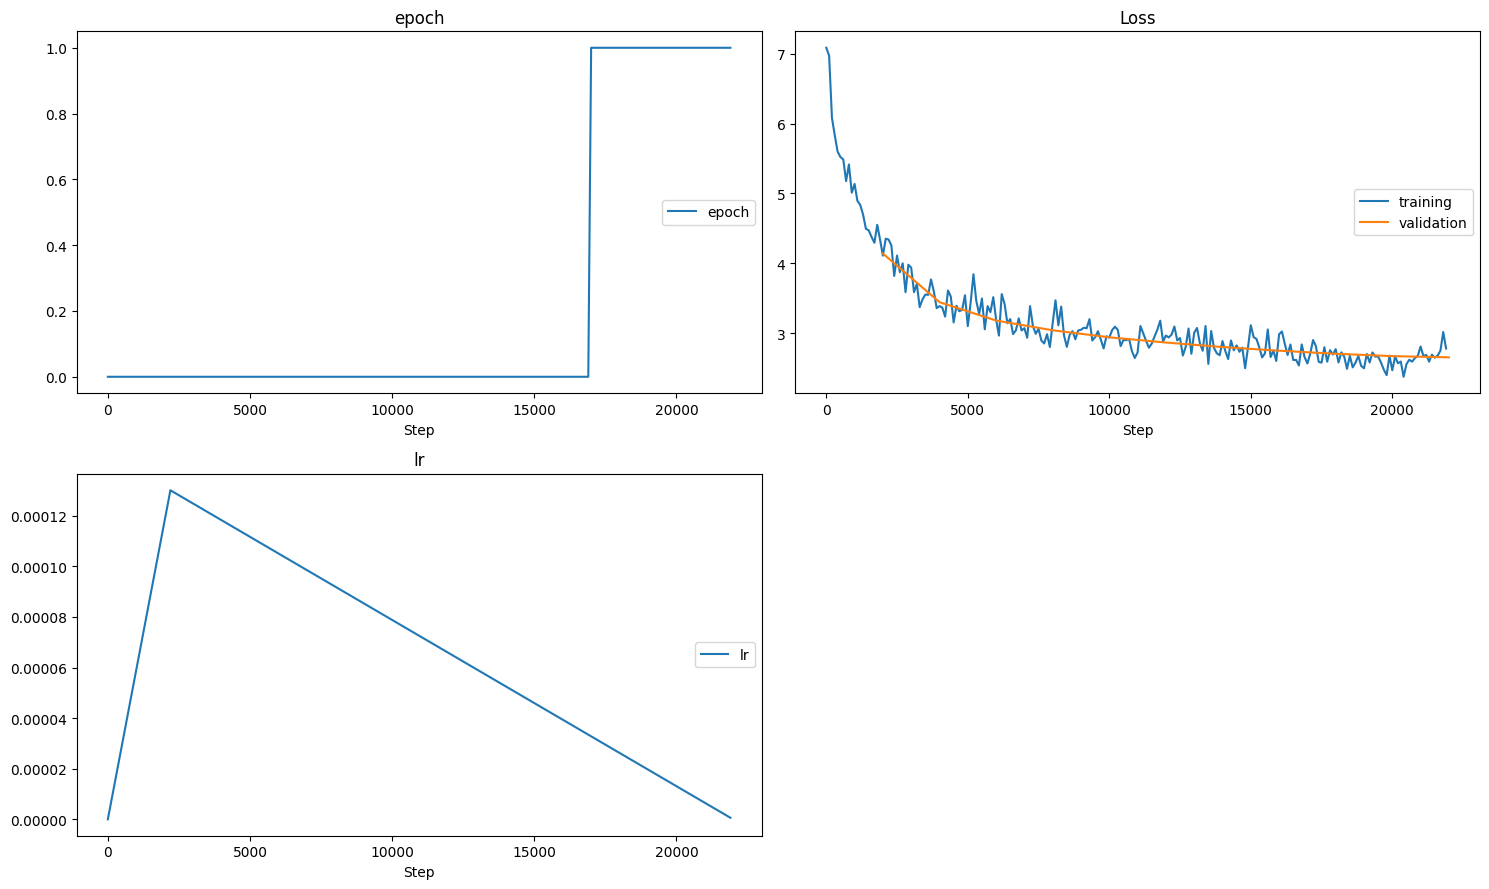

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    2.375, max:    7.086, cur:    2.779)
	validation       	 (min:    2.653, max:    4.139, cur:    2.653)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [ ]:

trainer.run(model, train_dataloader, test_dataloader)

In [ ]:
model.eval()

text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
''
output_ids = model.generate(
    input_ids
    ,
    max_new_tokens=100,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,       # Ограничиваем выбор 40 лучшими вариантами
    temperature=0.5 # <--- Ставим 0.5. Чем меньше число, тем "адекватнее" (но скучнее) текст
)

print(tokenizer.decode(output_ids[0].tolist()))

Заходит в бар к врачу и говорит:
 - Кто там?
 - Мужик, ты как вчера вечером сегодня вечером вырвал?
 - Да, но у меня нет много, но ведь у меня нет никаких денег.
 


In [ ]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rse-hw1/model.safetensors:   0%|          |  555kB /  305MB            

CommitInfo(commit_url='https://huggingface.co/pdanich/llm-course-hw1/commit/e35f80009b5d3fadd1f850ec80dbac3d75aaf7f2', commit_message='Push model using huggingface_hub.', commit_description='', oid='e35f80009b5d3fadd1f850ec80dbac3d75aaf7f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/llm-course-hw1'), pr_revision=None, pr_num=None)

Поиграйтесь с гиперпараметрами, попробуйте обучить `mini` и `small` версии.
Постарайтесь добиться как можно более высокого качества как в терминах лосса, так и при визуальной оценке генерации.

### Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Реализовать Rotary Positional Embedding **[2 балла]**
- Реализовать Multi-Head Latent Attention **[1 балл]**
- Оформить репозиторий на 🤗: карточка модели с описанием задания, репортом качества и примерами генерации **[1 балл]**

# Специальный раздел для проверяющего

In [ ]:
device = torch.device("cuda")

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)
check_model = TransformerForCausalLM.from_pretrained(REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

In [ ]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text), device=device)
model_output = check_model.generate(
    input_ids[None, :], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())